In [56]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [57]:
col = ['1/Q','1/Q_err','T']
data = pd.read_csv('Fitted.csv',delimiter='\t',usecols=col)

In [58]:
x = np.array(data['T'],dtype=float)
y = np.array(data['1/Q'],dtype=float)
yerr = np.array(data['1/Q_err'],dtype=float)

In [59]:
KB = c.Boltzmann
hbar = c.Planck

In [60]:
omega=5*1e9
alpha = 0.8

In [61]:
def D(x,y):
    der = np.zeros(len(x))
    for i in range(len(x)-1):
        n = y[i+1] - y[i]
        d = x[i+1] - x[i]
        der[i] = n/d
    return der 

IndexError: index 6 is out of bounds for axis 0 with size 6

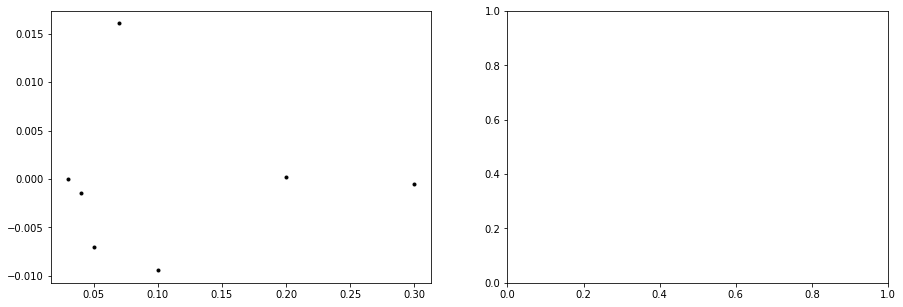

In [62]:
der = D(x,y)

fig, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15,5))
ax[0].scatter(x,D(x,y),marker='.',label=r'$\frac{d(\frac{1}{Q})}{dT}$',color='black')
ax[1].scatter(x[np.where(x<0.22)],D(x[np.where(x<22)],y[np.where(x<0.22)]),marker='.',label=r'$\frac{d(\frac{1}{Q})}{dT}$',color='black')
ax[0].set_xlabel('T[K]')
ax[1].set_xlabel('T[K]')
ax[0].set_title('Discrete Derivative')
ax[1].set_title('Zoom')
ax[0].legend(loc='upper left')
#plt.axhline(threshold, color='green', lw=2, alpha=0.7)
ax[0].fill_between(x, -0.0001, 0.0001, where=x<22, color='#069AF3',alpha=0.6)
ax[1].set_facecolor('#069AF3')
ax[0].grid()
ax[1].grid()

Dire che possiamo usare i punti a $T<0.22K$ per trovare una stima iniziale del parametro $Q_{0}$

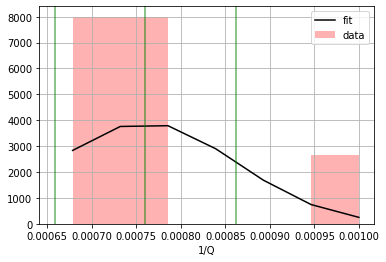

In [63]:
from scipy.stats import norm
import statistics
   
idx = np.where(x<22)
datas = y[idx]
step = (max(datas) - min(datas))/6
x_axis = np.arange(min(datas)-1e-7, max(datas)+1e-7, step)
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
mu, std = norm.fit(datas)
dist = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, norm.pdf(x_axis, mu, std),color='black',label='fit')
plt.hist(datas, bins='auto', density=True, alpha=0.3, color='red',label='data')
plt.axvline(x=mu, color='green', alpha=0.6)
plt.axvline(x=mu+std, color='green', alpha=0.6)
plt.axvline(x=mu-std, color='green', alpha=0.6)
#plt.text(mu , 3*1e6, r'$\mu$'+'='+f'{mu*1e5:.2f}*1e-5')
#plt.text(mu+std, 0.5*1e6, r'$\mu+\sigma$')
#plt.text(mu-std, 0.5*1e6, r'$\mu-\sigma$')
plt.xlabel('1/Q')
plt.grid()
plt.legend()

In [64]:
q0=1/mu

Non è un gran fit...però la stima di $Q_{0}$ sembra ragionevole...

In [65]:
def QT(T,d0):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T,d0, b, T_k):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

Parametri iniziali

In [66]:
d0 = 4.8*1e-23
b= 1e-6
T_k = 0.3

Plottiamo

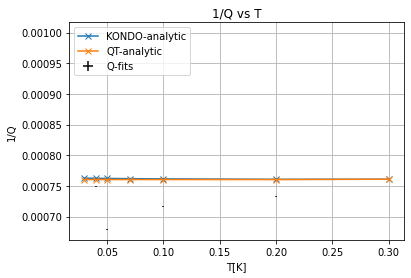

In [67]:
plt.plot(x,kondo(T=x,d0=d0,b=b,T_k=T_k),marker='x',label='KONDO-analytic')
plt.errorbar(x,y,xerr=0,yerr=yerr,alpha=1, color='black',label='Q-fits',marker='o',fmt='none')
plt.plot(x,QT(T=x,d0=d0),marker='x',label='QT-analytic')
plt.ylabel('1/Q')
plt.xlabel('T[K]')
plt.legend(loc='upper left')
plt.title('1/Q vs T')
plt.grid()

Pare che considerando l'effetto KONDO la discesa iniziale prima del ginocchio venga presa meglio dal fit

In [55]:
bounds = ([4.7*1e-23,4.7*1e-7,0.03],[4.75*1e-23,4.9*1e-7,0.5])
popt,pcov = curve_fit(kondo, x, y, p0=[d0,4.8e-7,0.035],sigma=yerr,maxfev=10000,bounds=bounds)
popt_nk,pcov_nk = curve_fit(QT, x, y, p0=[d0],sigma=yerr,maxfev=10000)

ValueError: `x0` is infeasible.

In [15]:
chi2 = 0
chi2_nk = 0
for i in range(len(y)):
    chi2 += ((y[i]-kondo(T=x[i],d0=popt[0],b=popt[1],T_k=popt[2]))/yerr[i])**2
    chi2_nk += ((y[i]-QT(T=x[i],d0=popt_nk[0]))/yerr[i])**2
chi2_0 = chi2/(len(x)-6)
chi2_0_nk = chi2_nk/(len(x)-6)

9.165546660404194
12.370121585542323


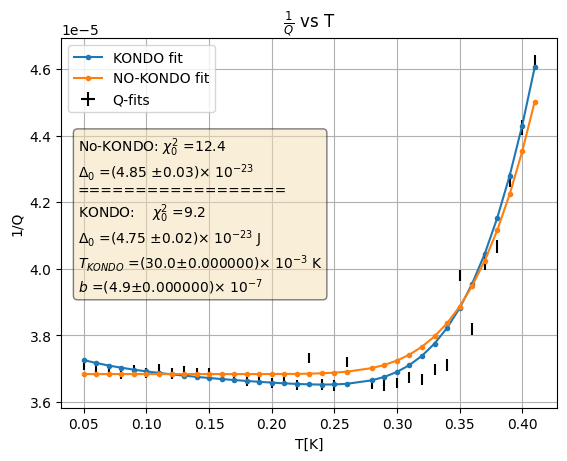

In [16]:
from matplotlib import lines as line
from matplotlib import colormaps as cmap
plt.errorbar(x,y,xerr=0,yerr=yerr,alpha=1, color='black',label='Q-fits',marker='.',fmt='none')
plt.plot(x,kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]),marker='.',label='KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x,QT(T=x,d0=popt_nk[0]),marker='.',label='NO-KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.ylabel('1/Q')
plt.xlabel('T[K]')
textstr = '\n'.join((
    r"No-KONDO: $\chi_{0}^2$ ="+f"{chi2_0_nk:.1f}",
    r"$\Delta_{0}$ ="+f"({popt_nk[0]*1e23:.2f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov_nk)[0])*1e23:.2f})"+r"$\times$ $10^{-23}$",
    r"==================",
    r"KONDO:    $\chi_{0}^2$ ="+f"{chi2_0:.1f}",
    r"$\Delta_{0}$ ="+f"({popt[0]*1e23:.2f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[0])*1e23:.2f})"+r"$\times$ $10^{-23}$"+" J",
    r"$T_{KONDO}$ ="+f"({popt[2]*1e3:.1f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[2])*1e3:.6f})"+r"$\times$ $10^{-3}$"+" K",
    r"$b$ ="+f"({popt[1]*1e7:.1f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[1])*1e7:.6f})"+r"$\times$ $10^{-7}$")
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.045, 4.4*1e-5, textstr, fontsize=10,verticalalignment='top', bbox=props)
plt.legend(loc='upper left')
plt.title(r'$\frac{1}{Q}$ vs T')
plt.grid()

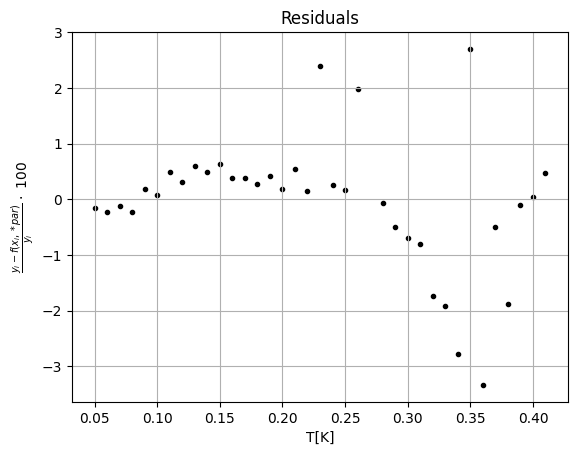

In [607]:
plt.scatter(x,(y-kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]))/y * 100,marker='.',label='Residuals',color='black')
plt.xlabel('T[K]')
plt.title('Residuals')
plt.ylabel(r'$\frac{y_{i}-f(x_{i},*par)}{y_{i}}\cdot$ 100')
plt.grid()